In [1]:
import numpy as np
from numpy.random import default_rng
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

In [2]:
# Creaiamo una funzione di utilità per il plot delle gaussiane stimate

def plot_esimate(mu, sigma, mu_hat, sigma2_hat, data, num_data):
    plt.figure(figsize=(7,7))
    
    plt.minorticks_on()
    
    x = np.linspace(mu - 3 *sigma, mu + 3 * sigma, 500)
    
    y = multivariate_normal([mu], [sigma**2])
    y_hat = multivariate_normal([mu_hat],[sigma2_hat])
    
    plt.scatter(data, np.zeros((num_data,)), marker='x', c='r', label='Campioni')
    plt.plot(x, y.pdf(x), label='Distribuzione teorica')
    plt.plot(x,y_hat.pdf(x),label='Distribuzione stimata')
    
    mse = np.sum((y.pdf(data)-y_hat.pdf(data))**2)/num_data
    
    plt.text(-0.6, 0.45,\
            f'Media stimata: {mu_hat:4.2f}\nVarianza stimata: {sigma2_hat:4.2f}\nMSE: {mse:6.4f}',\
            fontsize=12)
    
    plt.legend()
    
    plt.show()

In [3]:
# Definiamo mu e sigma e num_data
mu = 1.5
sigma = 0.7
num_data = 100

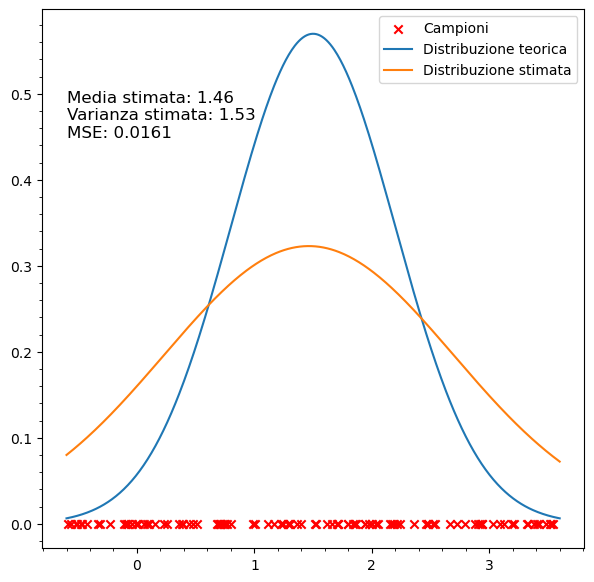

In [4]:
# Campionamento uniforme
rg = default_rng()

data = rg.uniform(mu - 3*sigma, mu + 3*sigma, num_data)

def uniform_estimate(data, num_data):
    
    mu_hat = np.sum(data)/num_data
    
    sigma2_hat = np.sum((data - mu_hat)**2)/(num_data - 1)
    
    return (mu_hat, sigma2_hat)

mu_hat, sigma2_hat = uniform_estimate(data, num_data)

plot_esimate(mu, sigma, mu_hat, sigma2_hat, data, num_data)

In [5]:
# Eseguiamo una simulazione stimando più volte i valori
# di media e varianza per vedere quanto valgono in valore atteso

simulations = 100

mhs = np.zeros((simulations,), dtype=np.float64)
sigmahs = np.zeros((simulations,), dtype=np.float64)

for i in range(simulations):
    
    data = rg.uniform(mu - 3*sigma, mu + 3*sigma, num_data)
    
    mhs[i], sigmahs[i] = uniform_estimate(data, num_data)

mh = np.sum(mhs)/simulations
sh = np.sum(sigmahs)/simulations

print(f'Valore atteso della media: {mh:4.2f}\nValore atteso della varianza: {sh:4.2f}')

Valore atteso della media: 1.49
Valore atteso della varianza: 1.45


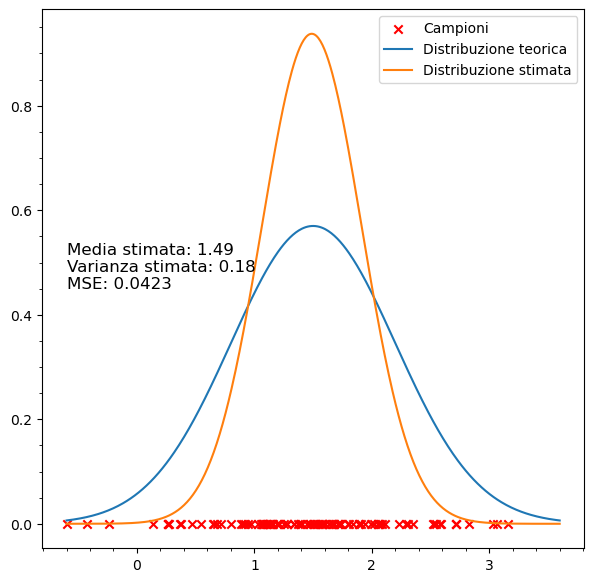

Varianza dello stimatore di media: 0.00035


In [6]:
# Campionamento stratificato usando come strati 
# gli intervalli di ampiezza sigma di una gaussiana

# S_k/S per k = 1, ..., 6
population_per_stratum = np.array([0.031, 0.136, 0.341, 0.341, 0.136, 0.031])

num_strata = 6

# Lista del numero dei campioni per strato n_k per k = 1, ..., 6
samples_per_stratum = np.array(num_data*population_per_stratum,dtype=int)

# Soluzione da adottare per avere n_k = costante
#samples_per_stratum = np.full((6,),2,dtype='int')

def stratified_estimate(num_strata, population_per_stratum, samples_per_stratum):
    
    data = np.empty((num_data,),dtype=np.float64)
    
    mu_per_stratum = np.empty((num_strata,),dtype='float64')
    sigma2_per_stratum = np.empty((num_strata,),dtype='float64')
    
    i = 0
    start = mu - 3*sigma
    
    # ci muoviamo strato per strato
    for k in range(0,len(samples_per_stratum)):
        
        data[i:i+samples_per_stratum[k]] = rg.uniform(start, start+sigma, samples_per_stratum[k])
        
        # stimiamo media e varianza di strato
        mu_per_stratum[k] = np.sum(data[i:i+samples_per_stratum[k]])/samples_per_stratum[k]
        sigma2_per_stratum[k] = np.sum((data[i:i+samples_per_stratum[k]]-mu_per_stratum[k])**2)\
                                            /(samples_per_stratum[k]-1)
                                    
        i = i + samples_per_stratum[k]
        start += sigma
    # Sommatoria con k di (S_k/S)*mu_k
    mu_hat = np.sum(population_per_stratum*mu_per_stratum)
    
    sigma2_hat = np.sum(sigma2_per_stratum)
    
    # Varianza dello stimatore di media
    var_mu_hat = np.sum((population_per_stratum**2)*sigma2_per_stratum/samples_per_stratum)
    
    return (mu_hat, sigma2_hat, var_mu_hat, data)

mu_hat, sigma2_hat, var_mu_hat, data = stratified_estimate(num_strata,\
                                                        population_per_stratum,\
                                                        samples_per_stratum)

plot_esimate(mu, sigma, mu_hat, sigma2_hat, data, num_data)

print(f'Varianza dello stimatore di media: {var_mu_hat:7.5f}')

In [7]:
# Simulazione su 100 run del campionamento stratificato
mhs = np.zeros((simulations,), dtype=np.float64)
sigmahs = np.zeros((simulations,), dtype=np.float64)

for i in range(simulations):
        
    mhs[i], sigmahs[i], _, _ = stratified_estimate(num_strata, population_per_stratum, samples_per_stratum)

mh = np.sum(mhs)/simulations
sh = np.sum(sigmahs)/simulations

print(f'Valore atteso della media: {mh:4.2f}\nValore atteso della varianza: {sh:4.2f}')

Valore atteso della media: 1.52
Valore atteso della varianza: 0.24


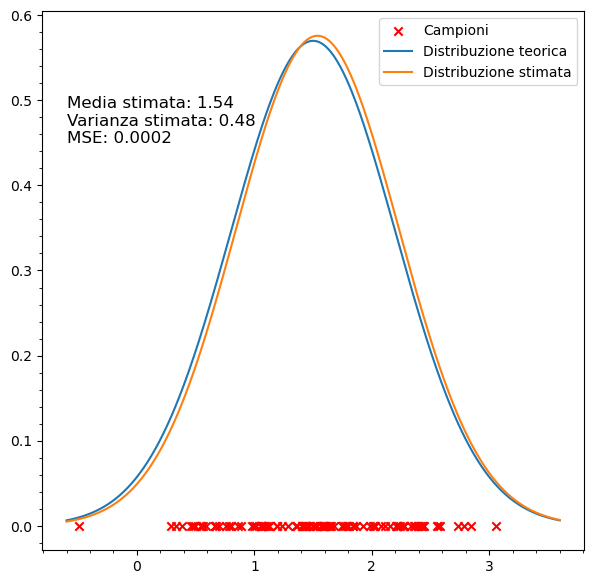

In [13]:
# Campionamento per importanza

def importance_estimate(num_data, scaling):
    
    rg = default_rng()
    
    # Estraggo i campioni per la funzione importanza con distribuzione uniforme
    samples_importance = rg.uniform(mu - 3 * sigma, mu + 3 * sigma, num_data)
    
    # Calcolo i parametri della funzione importanza come stime campionarie
    # sui valori estratti tramite distribuzione uniforme
    mu_importance = np.sum(samples_importance)/num_data
    
    sigma2_importance = np.sum((samples_importance-mu_importance)**2)/(num_data-1)
    
    # Campiono i dati per la stima tramite la funzione importanza
    data = rg.normal(mu_importance, scaling*np.sqrt(sigma2_importance),num_data)
    
    # Stimo media e varianza dei dati
    mu_hat = np.sum(data)/num_data
    sigma2_hat = np.sum((data - mu_hat)**2)/(num_data-1)
    
    return (mu_hat, sigma2_hat, data)


mu_hat, sigma2_hat, data = importance_estimate(num_data, 0.55)

plot_esimate(mu, sigma, mu_hat, sigma2_hat, data, num_data)  

In [15]:
def simulation(num_data, sim=100, scale=0.7):
    
    mh = np.zeros((sim,),dtype='float64')
    sh = np.zeros((sim,),dtype='float64')
    
    for i in range(sim):
        
        mh[i], sh[i], _ = importance_estimate(num_data, scale)
    
    
    mh_hat = np.sum(mh)/sim
    sh_hat = np.sum(sh)/sim
    
    return (mh_hat, sh_hat)

mh_hat, sh_hat = simulation(num_data)

print(f'Valore atteso della media: {mh_hat:4.2f}\nValore atteso della varianza: {sh_hat:4.2f}')

Valore atteso della media: 1.52
Valore atteso della varianza: 0.72


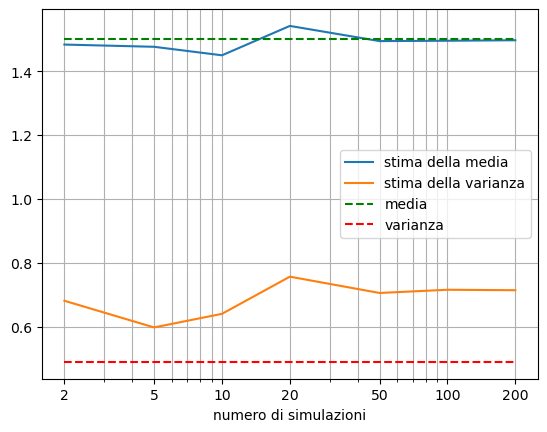

In [17]:
# Creiamo i grafici che rappresentano l'andamento dei valori attesi
# di media e varianza al variare del numero di simulazioni e del 
# paramtro di scaling

runs = np.array([2, 5, 10, 20, 50, 100, 200])

mhs = np.empty((7,),dtype='float64')
shs = np.empty((7,),dtype='float64')

x = np.arange(2, 201, 1)

med = np.full((199,),mu)
var = np.full((199,),sigma**2)

for i in range(len(runs)):
    
    mhs[i], shs[i] = simulation(num_data, sim=runs[i])

plt.grid(True, which='both')

plt.semilogx(runs, mhs, label='stima della media')
plt.semilogx(runs, shs, label='stima della varianza')

plt.xlabel('numero di simulazioni')
plt.xticks(runs, runs)

plt.plot(x, med, 'g--', label='media')
plt.plot(x, var, 'r--', label='varianza')

plt.legend()

plt.show()


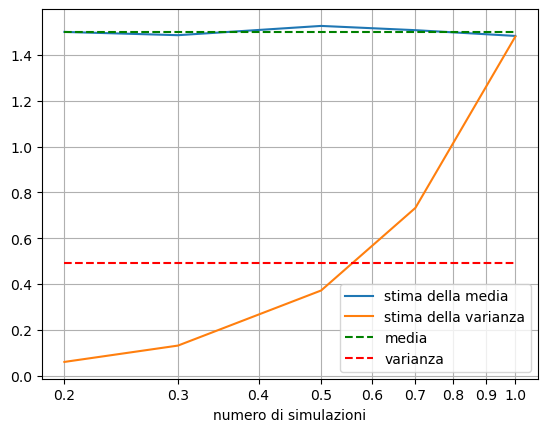

In [18]:
# Creiamo i grafici che rappresentano l'andamento dei valori attesi
# di media e varianza al variare del numero di simulazioni e del 
# paramtro di scaling

scales = np.array([0.2, 0.3, 0.5, 0.7, 1.0])

mhs = np.empty((5,),dtype='float64')
shs = np.empty((5,),dtype='float64')

x = np.arange(0.2, 1.05, 0.05)

med = np.full((len(x),),mu)
var = np.full((len(x),),sigma**2)

for i in range(len(scales)):
    
    mhs[i], shs[i] = simulation(num_data, scale=scales[i])

plt.grid(True, which='both')

plt.semilogx(scales, mhs, label='stima della media')
plt.semilogx(scales, shs, label='stima della varianza')

plt.xlabel('numero di simulazioni')
plt.xticks([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

plt.plot(x, med, 'g--', label='media')
plt.plot(x, var, 'r--', label='varianza')

plt.legend()

plt.show()